In [1]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import pickle
from collections import defaultdict
from itertools import groupby
from scipy import stats

import seaborn as sns
from tqdm import tqdm
#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower


HOME="/linkhome/rech/genini01/ucv88ce/"
#10 ms per cluster unit

In [2]:
def get_w2u(quantized_txt):
    #remove first and last token
    w2u = {l.strip().split("\t")[0] : [x for x in l.strip().split("\t")[1].split(',')] for l in open(quantized_txt, 'r')}
    return w2u
    
def remove_sil(w2u, phone_ali):
    
    phone_ali['wav'] = phone_ali['wav'].apply(lambda x: x.split('-')[1])
    sil_phones = phone_ali[phone_ali["phone"]=="SIL"].copy(deep=True)
    sil_phones['units_location'] = sil_phones.apply(lambda x: (math.ceil(x["onset"]*100), math.ceil(x["onset"]*100+(x["dur_ms"]/10))), axis=1)

    w2u =  {k.split('.')[0]:v for k,v in w2u.items()} #same audio wav format
    
    wav_to_remove = set()
    for index, row in sil_phones.iterrows():
        if row['wav'] in w2u:
            for x in range(row['units_location'][0], row['units_location'][1]):
                if w2u[row['wav']][x]:
                    w2u[row['wav']][x] = None    
        else : 
            wav_to_remove.add(row['wav'])
            
    #remove the wav which didn"t exist 
    phone_ali = phone_ali[~phone_ali['wav'].isin(wav_to_remove)]
    phone_ali_nosil = phone_ali[phone_ali["phone"]!="SIL"].copy(deep=True)
    return w2u, phone_ali_nosil, phone_ali #still return phone_ali cause need it in some cases

def correct_w2u(w2u, lang):
    w2u_corr = {}
    for k,v in w2u.items():
        groups = groupby(v)
        #w2u_corr[k] = [(label, sum(1 for _ in group)) for label, group in groups]
        w2u_corr[k+"_"+lang] = [(label, sum(1 for _ in group)*10) for label, group in groups] #put it in MS (the x10)

    return w2u_corr

def get_phone_ali(ali_ctm, lang):
    phone_ali = pd.read_csv(ali_ctm, sep=" ", header=None)
    phone_ali.columns=["wav", "num", "onset", "dur_s", "phone_long", "None"]
    phone_ali["phone"] = phone_ali["phone_long"].apply(lambda x: x.split("_")[0])
    phone_ali["dur_ms"] = phone_ali["dur_s"].apply(lambda x: x*1000)

    if lang=="fr":
        phone_ali['phone'] = phone_ali['phone'].replace("au", "oo")
    return phone_ali
    
    
def get_units_df(w2u):
    units_tmp = defaultdict(list)
    units_full = []
    for v in w2u.values():
        for x in v:
            if not x[0]:
                continue
            units_tmp[x[0]].append(x[1])
            units_full.append(x)
    units  = {k: [len(v), np.mean(v), np.sum(v), ] for k,v in units_tmp.items()}
    df_units_full = pd.DataFrame(units_full, columns=['unit', 'dur'])
    
    df_units = pd.DataFrame.from_dict(units, orient='index', columns =["num_items","dur_avg", "dur_total"])
    df_units['type'] = 'unit'
    df_units['col'] = 'red'
    
    return df_units.dropna(), df_units_full.dropna()
    
def get_phone_df(phone_ali):
    df_phone = phone_ali.groupby(by="phone").agg(
            dur_avg= ("dur_ms", "mean"),
            dur_total= ("dur_ms", "sum"),
            num_items= ("phone", "count"),)
    df_phone['type'] = 'phone'
    df_phone['col'] = 'green'
    return df_phone

def get_df_full(phone_ali, df_units_full):
    df_phone_full = phone_ali[["phone","dur_ms"]]

    df_phone_full['type'] = "phone"
    df_units_full['type'] = "unit"

    df_phone_full = df_phone_full.rename(columns={"phone":"token", "dur_ms":"dur"})
    df_units_full = df_units_full.rename(columns={"unit":"token"})

    df_full = df_units_full.append(df_phone_full)
    return df_full

In [3]:
en_phone_char = {
    'dh': 'plosive', 'ah':'vowel', 'v':'fricative', 'ae':'vowel', 'l':'semi-vowel', 'iy':'vowel',
    'w':'semivowel', 'z':'fricative', 'f':'fricative', 'ih':'vowel', 'd':'plosive', 'th':'fricative',
    'eh':'vowel', 'n':'nasal', 's':'fricative', 'ao':'vowel', 'g':'plosive', 'jh':'affricate', 'k':'plosive',
    'm':'nasal', 'ay':'vowel', 'er':'vowel', 'ow':'vowel', 'r':'semi-vowel', 'y':'vowel', 'uw':'vowel', 
    'hh':'fricative', 't':'plosive', 'p':'plosive', 'sh':'fricative', 'uh':'vowel', 'aa':'vowel', 'ng':'nasal', 
    'ey':'vowel', 'b':'plosive', 'aw':'plosive', 'ch':'affricate', 'oy':'vowel', 'zh':'fricative'
}


First we remove units which have been mapped to SILENCE parts (as definaed by the alignment file)
We also remove the SIL phone

In [4]:
lang="en"
dfs = []
dfs_full = []
NCLUSTER=50


km_units = "/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/{}/3200h/00/kmeans{}/quantized_outputs.txt".format(lang.upper(), NCLUSTER)
ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)

w2u = get_w2u(km_units)
phone_ali = get_phone_ali(ali_ctm, lang)
w2u, _, phone_ali = remove_sil(w2u, phone_ali) #keep silence from phone_ali and w2u


In [5]:
def ali_to_frame_ali(phone_ali):
    #w2ph
    w2p = defaultdict(list)
    
    curr_wav=None
    for index, row in tqdm(phone_ali.iterrows()):
        if curr_wav!= row["wav"]:
            i=0.0
        
        num_unit_repetition = round((row['dur_ms']/10))
        
        
        w2p[row["wav"]].extend([row["phone"]]*num_unit_repetition)
    return w2p

def get_w2t(w2p, w2u):
    w2t = {}
    for k, v in tqdm(w2p.items()):

        w2t[k] = [(x, y) for x,y in zip(v, w2u[k])]

    return w2t
            

In [6]:
w2p = ali_to_frame_ali(phone_ali)

#below create the W2token 
w2t = get_w2t(w2p, w2u)
w2t_corr = {}
for k,v in w2t.items():
    groups = groupby(v)
    #w2u_corr[k] = [(label, sum(1 for _ in group)) for label, group in groups]
    w2t_corr[k+"_"+lang] = [(label, sum(1 for _ in group)) for label, group in groups] #put it in MS (the x10)


287894it [00:22, 12731.59it/s]
100%|██████████| 7042/7042 [00:00<00:00, 10280.41it/s]


In [7]:
p2u = {}
u2p = {}
for v in w2t.values():
    for phone, unit in v:
    #phone = v[0]
    #unit = v[1]
        if phone == "SIL" or not unit: #remove silences and Nans
            continue
        if phone not in p2u : 
            p2u[phone] = defaultdict(int)
        if unit not in u2p:
            u2p[unit] = defaultdict(int)

        p2u[phone][unit]+=1
        u2p[unit][phone]+=1

    #need ot remove silence

In [8]:
u2p_df = pd.DataFrame(u2p).fillna(0)
# below not that useful
u2p_df_prob = u2p_df.apply(lambda x : x/x.sum()) #LA PROBA SE LIT PAR colonne (a confirmer)


p2u_df = pd.DataFrame(p2u).fillna(0)

# below not that useful 
p2u_df_prob = p2u_df.apply(lambda x : x/x.sum()) #LA PROBA SE LIT PAr COLONNE (a confirmer)


#p2u_entropy = p2u_df.apply(stats.entropy)
#Not in base e but in base number of categories ? Should it be number of categories of phones or unit? Here do num of unit makes more sense
p2u_entropy = p2u_df.apply(lambda x : stats.entropy(x, base=len(x)))
p2u_entropy = pd.concat([p2u_entropy, pd.Series(en_phone_char)], keys=['entropy', 'char'], axis=1)


#u2p_entropy = u2p_df.apply(stats.entropy)
u2p_entropy = u2p_df.apply(lambda x : stats.entropy(x, base=len(x)))


In [9]:
p2u_df_prob

,dh,ah,v,ae,l,iy,w,z,f,ih,...,sh,uh,aa,ng,ey,b,aw,ch,oy,zh
12,0.062486,0.002886,0.000865,0.007372,0.003867,0.001692,0.015747,0.003215,0.005506,0.009345,...,0.006270,0.000325,0.001657,0.002937,0.000864,0.017337,0.000660,0.002332,0.000641,0.000000
30,0.146100,0.010566,0.007626,0.019690,0.008135,0.005749,0.044616,0.003750,0.031700,0.021831,...,0.017126,0.004063,0.007941,0.003250,0.002368,0.043830,0.001792,0.005152,0.001496,0.000000
32,0.054619,0.003411,0.002437,0.006629,0.004845,0.002645,0.024183,0.004518,0.011772,0.007838,...,0.006676,0.000163,0.002389,0.005129,0.001328,0.024816,0.001179,0.003688,0.000000,0.000000
1,0.013711,0.017881,0.000210,0.106018,0.000777,0.003752,0.001767,0.000141,0.000637,0.066089,...,0.000406,0.000650,0.007339,0.001723,0.016270,0.003219,0.007356,0.000163,0.000000,0.000000
41,0.129143,0.037178,0.005556,0.004215,0.004031,0.003455,0.000562,0.003862,0.000986,0.011796,...,0.000031,0.002600,0.000301,0.000861,0.005407,0.005466,0.000943,0.000054,0.000000,0.000000
37,0.099523,0.009288,0.075445,0.000705,0.012523,0.009915,0.013685,0.006421,0.003451,0.005125,...,0.000842,0.007964,0.000603,0.053446,0.001664,0.231087,0.001037,0.012745,0.000641,0.002934
26,0.020654,0.023843,0.010273,0.002845,0.012961,0.012219,0.006829,0.001612,0.000288,0.015993,...,0.000281,0.002113,0.002712,0.366014,0.008111,0.005399,0.006460,0.000759,0.005558,0.001467
46,0.062811,0.080929,0.022301,0.020917,0.053829,0.053418,0.031627,0.016302,0.012429,0.121508,...,0.020464,0.081099,0.005552,0.009005,0.035772,0.043830,0.008299,0.019578,0.012398,0.068460
33,0.030619,0.034107,0.029481,0.004998,0.008281,0.036071,0.000455,0.005540,0.006636,0.047938,...,0.005334,0.072973,0.008931,0.014722,0.028365,0.011435,0.004810,0.069038,0.007054,0.007335
27,0.007792,0.000642,0.001074,0.000026,0.000082,0.000081,0.000134,0.195558,0.009820,0.000524,...,0.004367,0.000000,0.000000,0.000000,0.000000,0.000402,0.000000,0.003471,0.000000,0.000489


In [10]:
p2u_max = pd.DataFrame(u2p_df.idxmax(axis=1), columns=["unit"])
p2u_max['phone'] = p2u_max.index
p2u_max = pd.concat([p2u_max, pd.Series(en_phone_char, name='char')], axis=1).sort_values(by="char")


u2p_max = pd.DataFrame(p2u_df.idxmax(axis=1), columns=["phone"])
u2p_max['unit'] = u2p_max.index


In [11]:
p2u_max

,unit,phone,char
jh,2,jh,affricate
ch,2,ch,affricate
zh,2,zh,fricative
z,38,z,fricative
v,22,v,fricative
th,31,th,fricative
s,27,s,fricative
hh,24,hh,fricative
sh,2,sh,fricative
f,31,f,fricative


In [25]:
{'dh': 'plosive', 'ah':'vowel', 'v':'fricative', 'ae':'vowel', 'l':'semi-vowel', 'iy':'vowel', 'w':'semi-vowel', 'z':'fricative', 'f':'fricative', 'ih':'vowel', 'd':'plosive', 'th':'fricative', 'eh':'vowel', 'n':'nasal', 's':'fricative', 'ao':'vowel', 'g':'plosive', 'jh':'affricate', 'k':'plosive', 'm':'nasal', 'ay':'vowel', 'er':'vowel', 'ow':'vowel', 'r':'semi-vowel', 'y':'vowel', 'uw':'vowel', 'hh':'fricative', 't':'plosive', 'p':'plosive', 'sh':'fricative', 'uh':'vowel', 'aa':'vowel', 'ng':'nasal', 'ey':'vowel', 'b':'plosive', 'aw':'plosive', 'ch':'affricate', 'oy':'vowel', 'zh':'fricative'}

{'dh': 'plosive',
 'ah': 'vowel',
 'v': 'fricative',
 'ae': 'vowel',
 'l': 'semi-vowel',
 'iy': 'vowel',
 'w': 'semi-vowel',
 'z': 'fricative',
 'f': 'fricative',
 'ih': 'vowel',
 'd': 'plosive',
 'th': 'fricative',
 'eh': 'vowel',
 'n': 'nasal',
 's': 'fricative',
 'ao': 'vowel',
 'g': 'plosive',
 'jh': 'affricate',
 'k': 'plosive',
 'm': 'nasal',
 'ay': 'vowel',
 'er': 'vowel',
 'ow': 'vowel',
 'r': 'semi-vowel',
 'y': 'vowel',
 'uw': 'vowel',
 'hh': 'fricative',
 't': 'plosive',
 'p': 'plosive',
 'sh': 'fricative',
 'uh': 'vowel',
 'aa': 'vowel',
 'ng': 'nasal',
 'ey': 'vowel',
 'b': 'plosive',
 'aw': 'plosive',
 'ch': 'affricate',
 'oy': 'vowel',
 'zh': 'fricative'}

(0.0, 1.2)

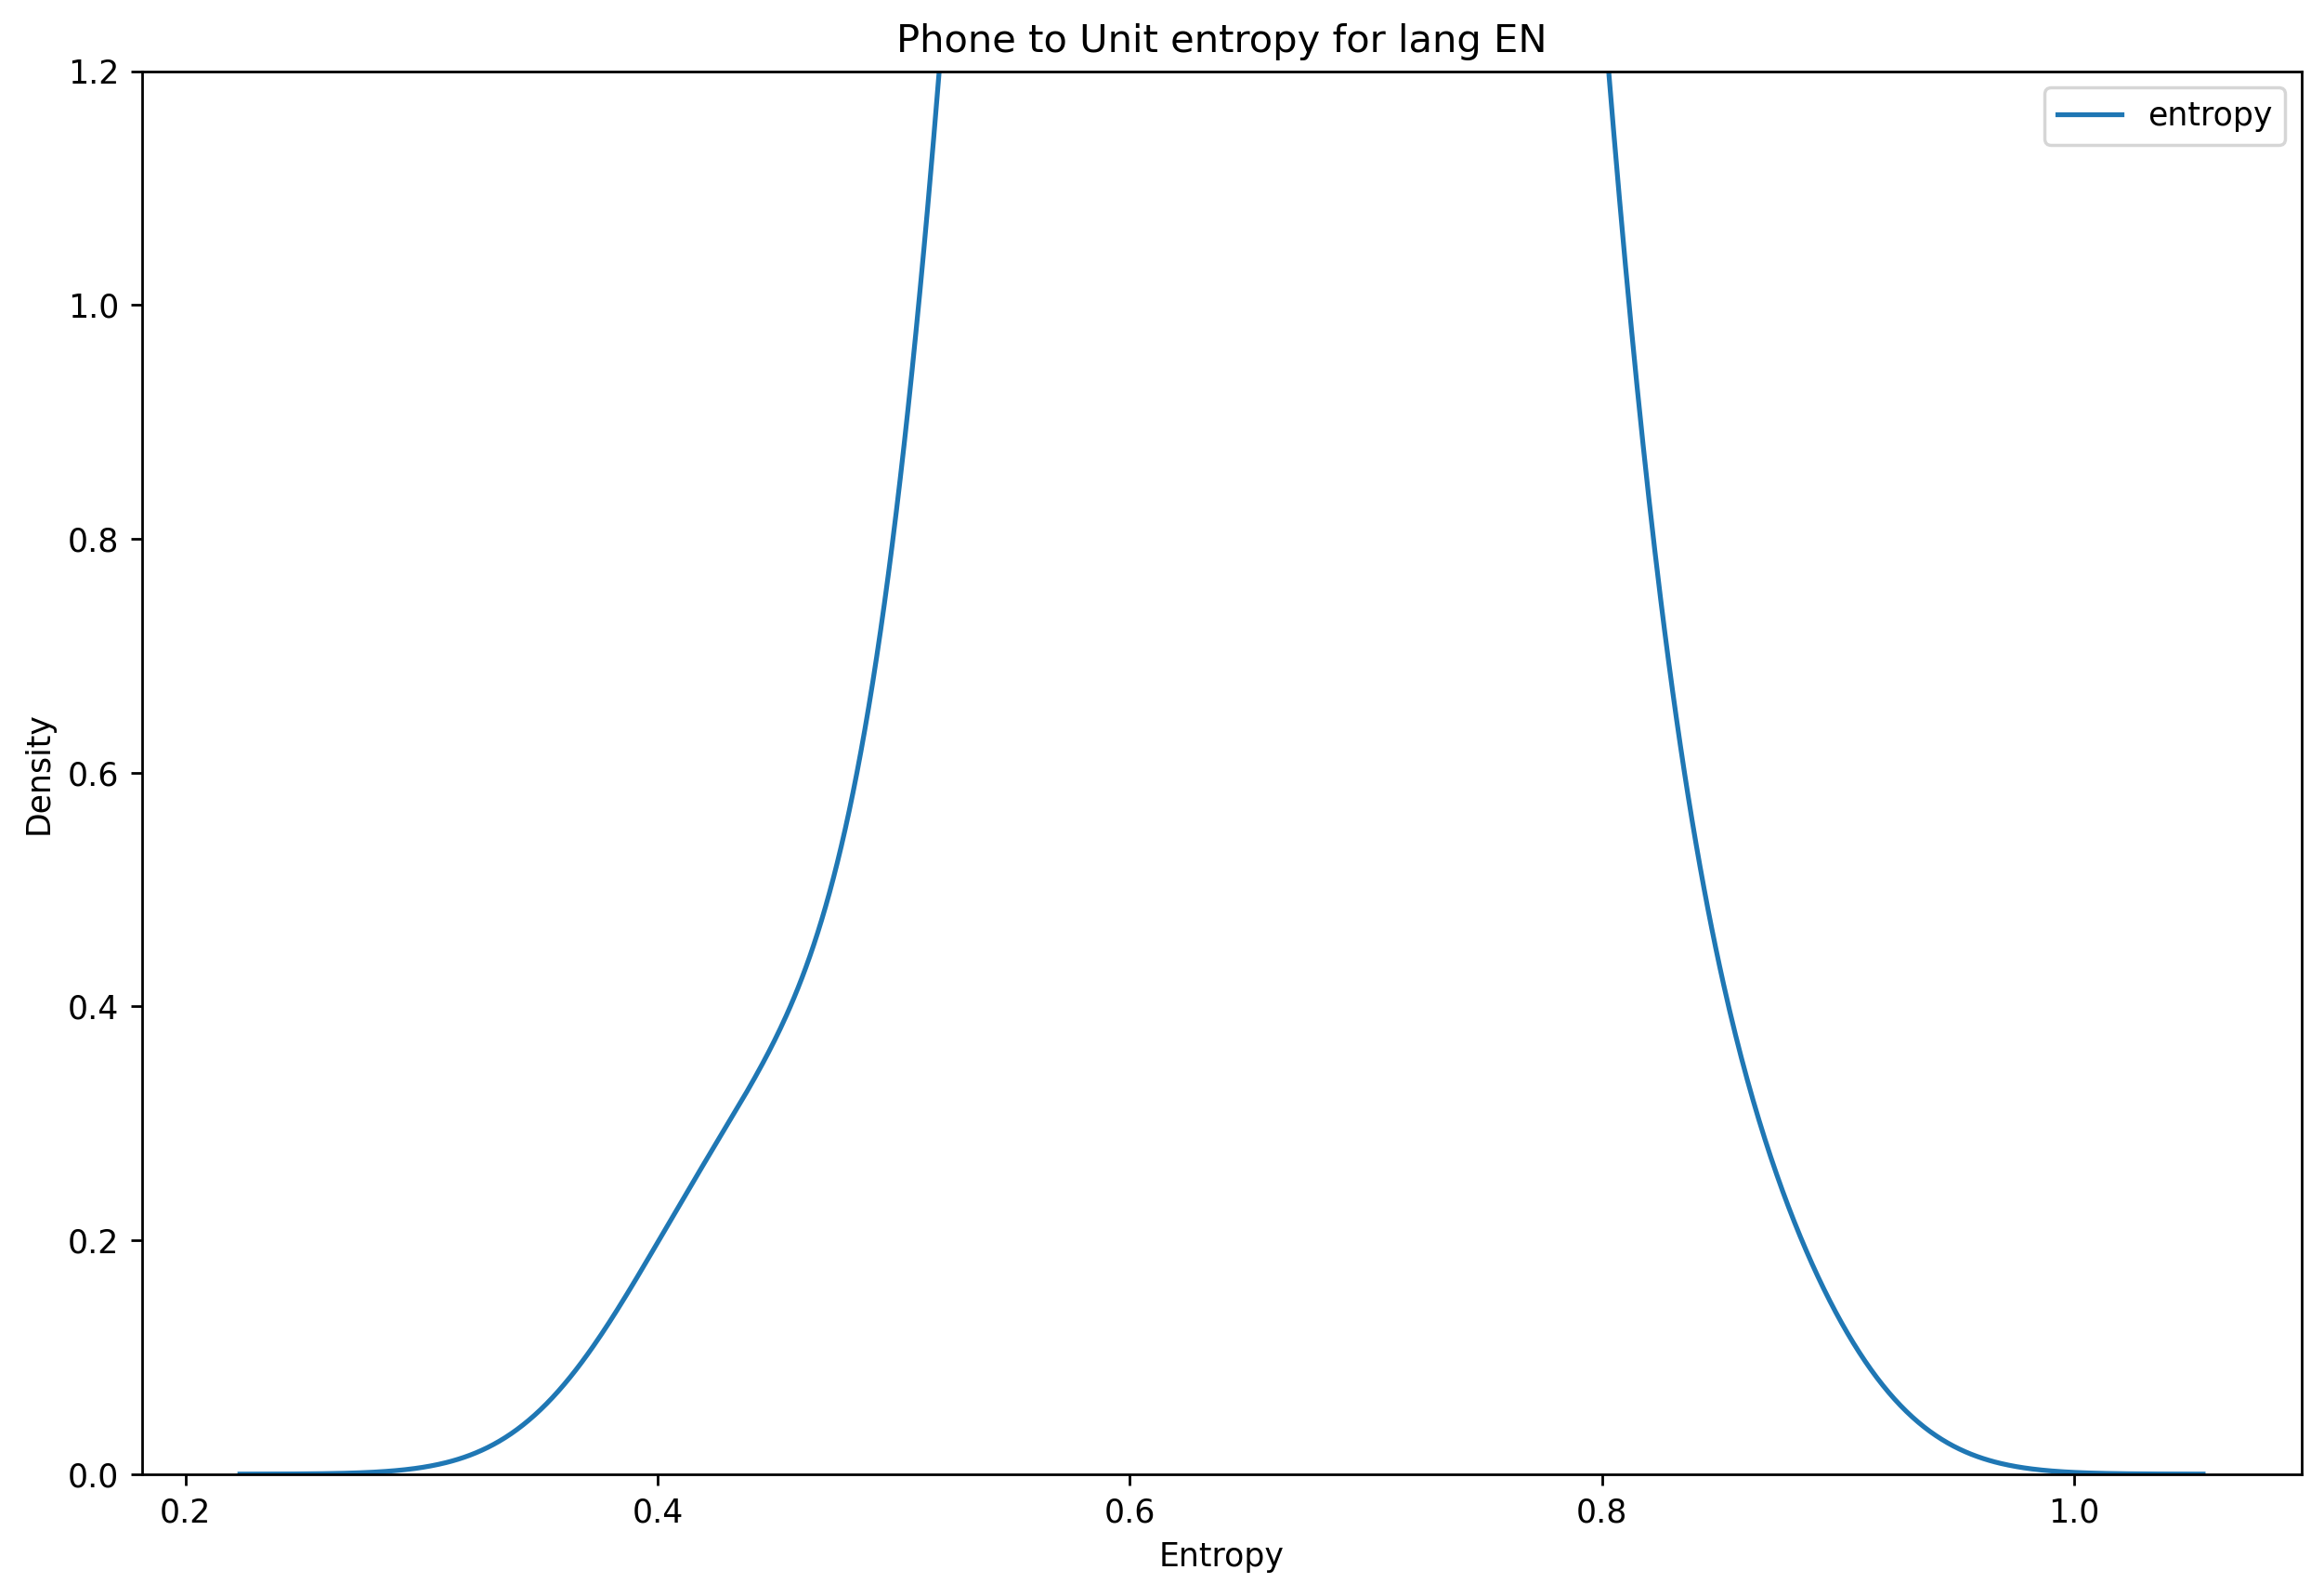

In [13]:
p2u_entropy.plot.kde(bw_method=0.6)
plt.title('Phone to Unit entropy for lang {}'.format(lang.upper()))
plt.xlabel("Entropy")
plt.ylim(0,1.2)

#p2u_entropy.plot.kde()

In [14]:
p2u_entropy.sort_values(by="entropy", ascending=False)

,entropy,char
ah,0.846684,vowel
ih,0.779692,vowel
uh,0.759468,vowel
dh,0.755138,plosive
hh,0.738713,fricative
th,0.733827,fricative
d,0.731325,plosive
t,0.730464,plosive
g,0.730263,plosive
v,0.718839,fricative


<AxesSubplot:xlabel='char'>

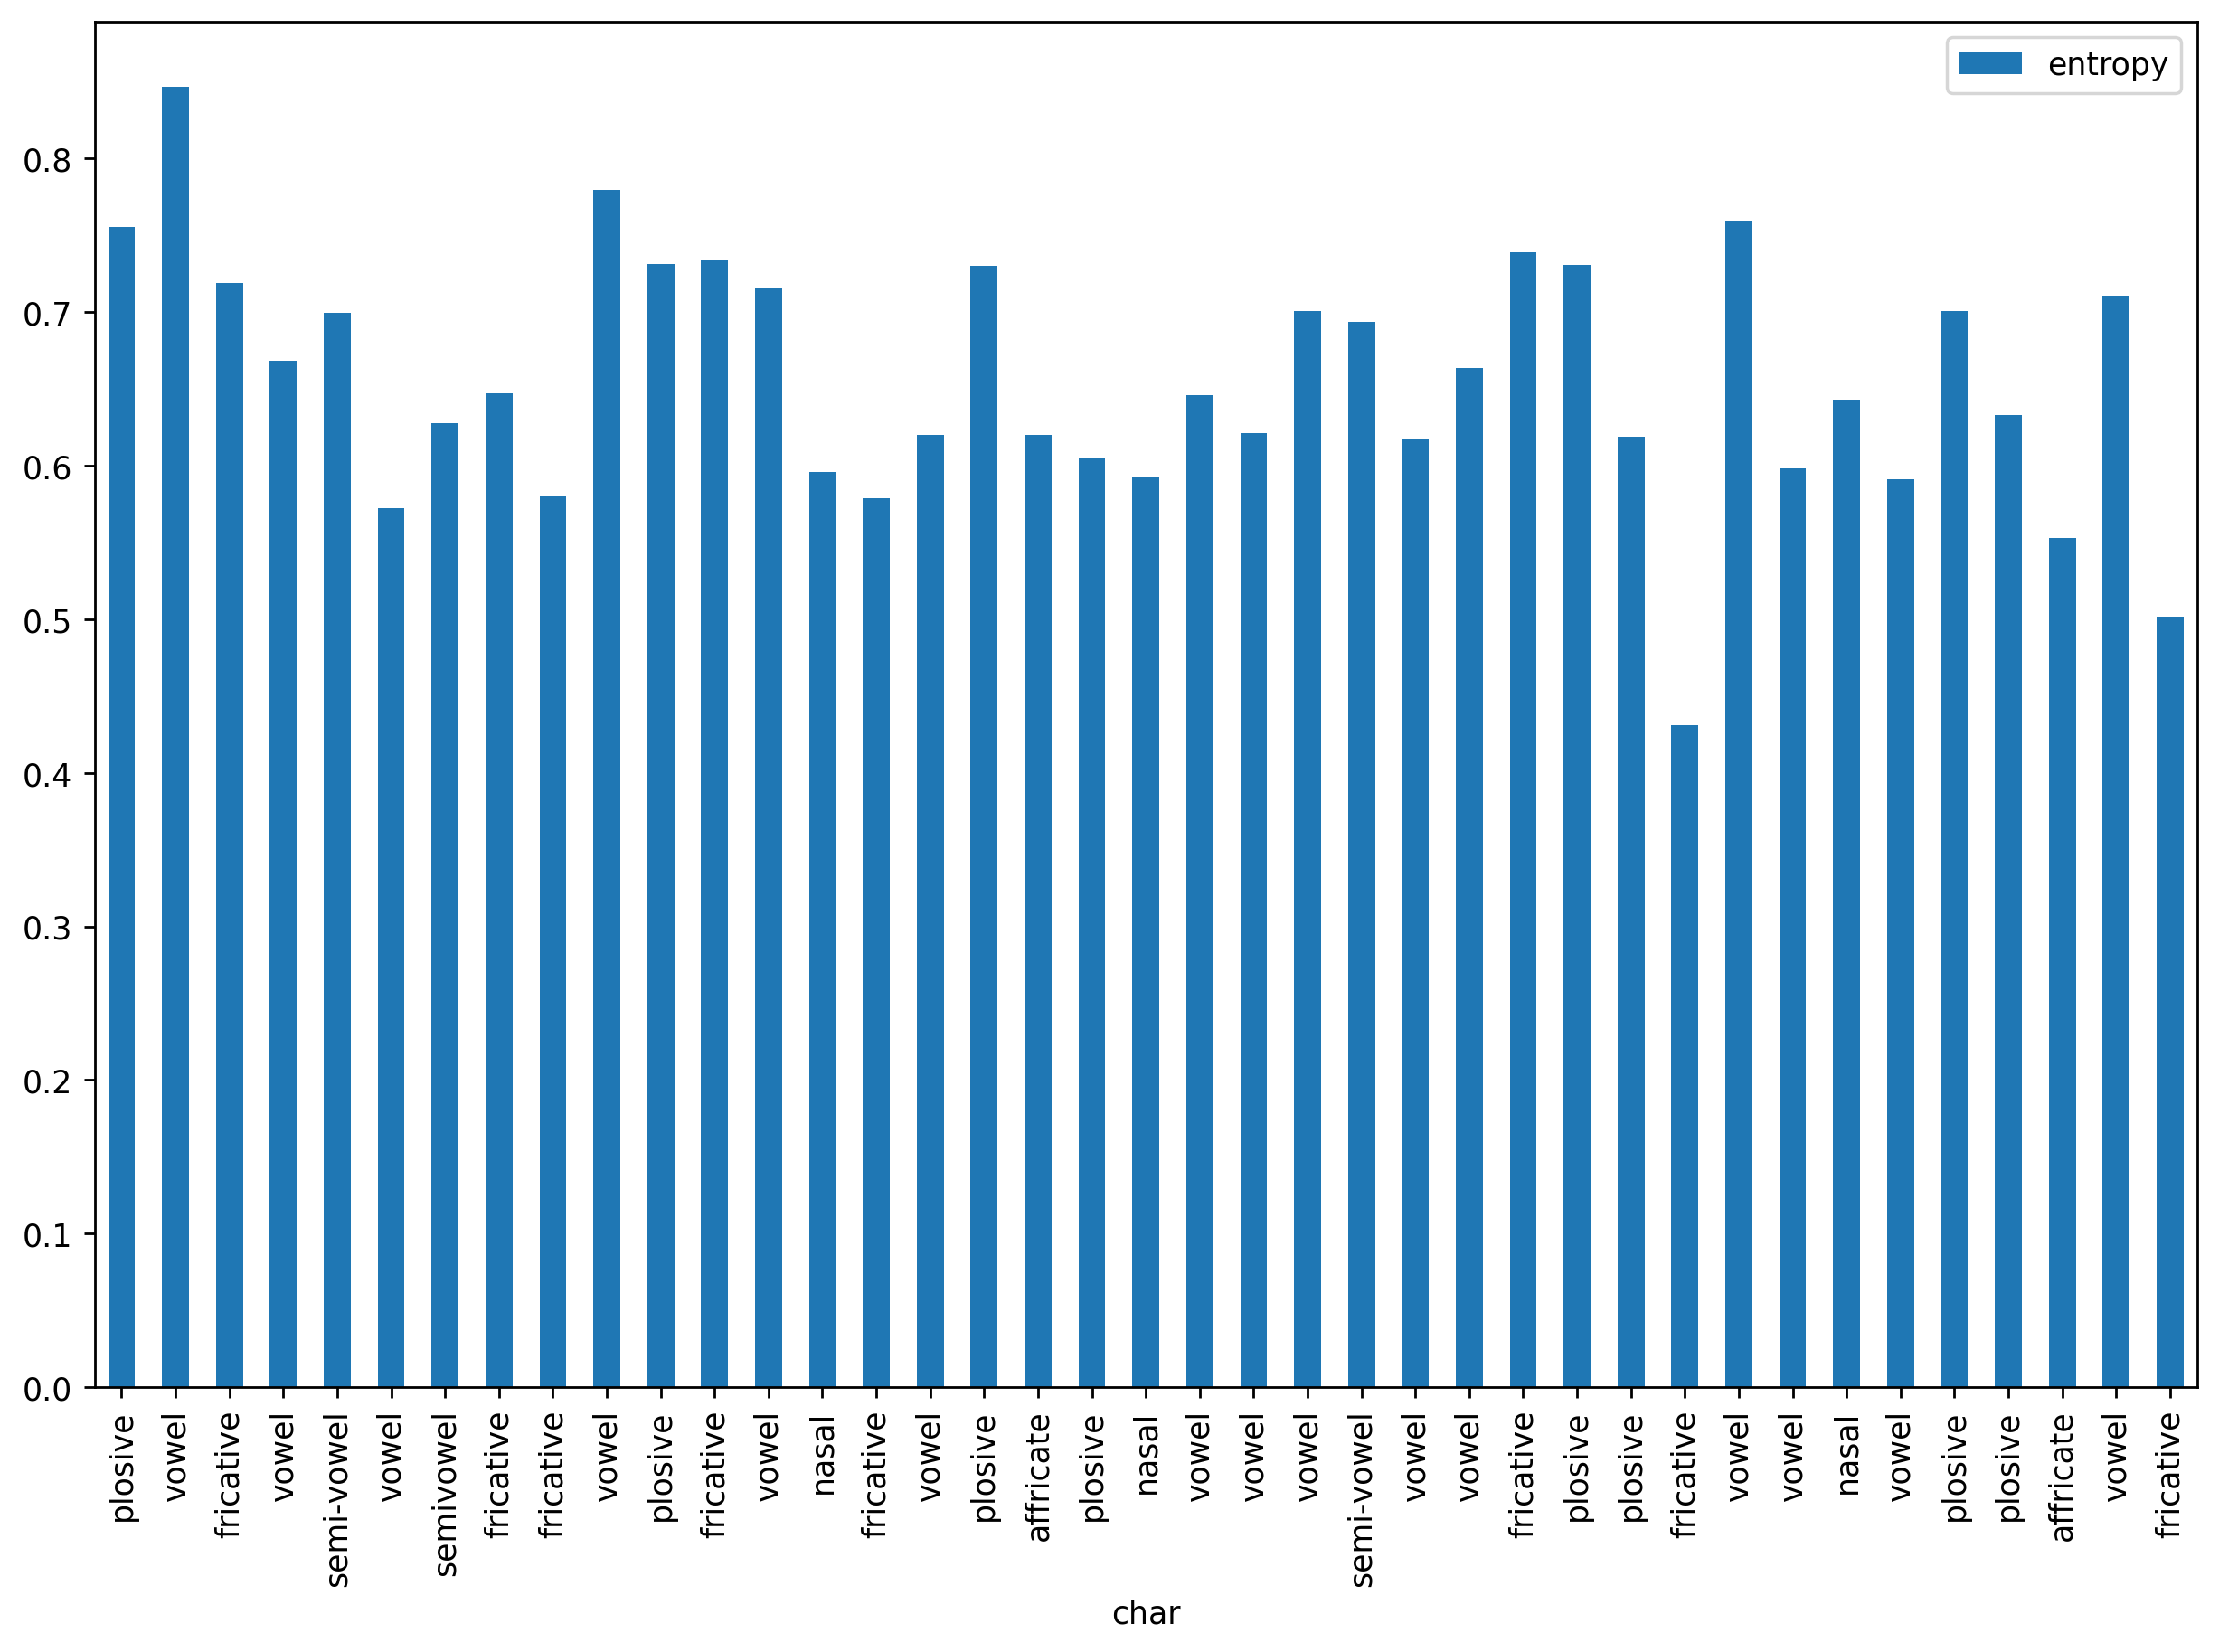

In [15]:
p2u_entropy.plot.bar(x='char', y ="entropy")

<AxesSubplot:xlabel='char'>

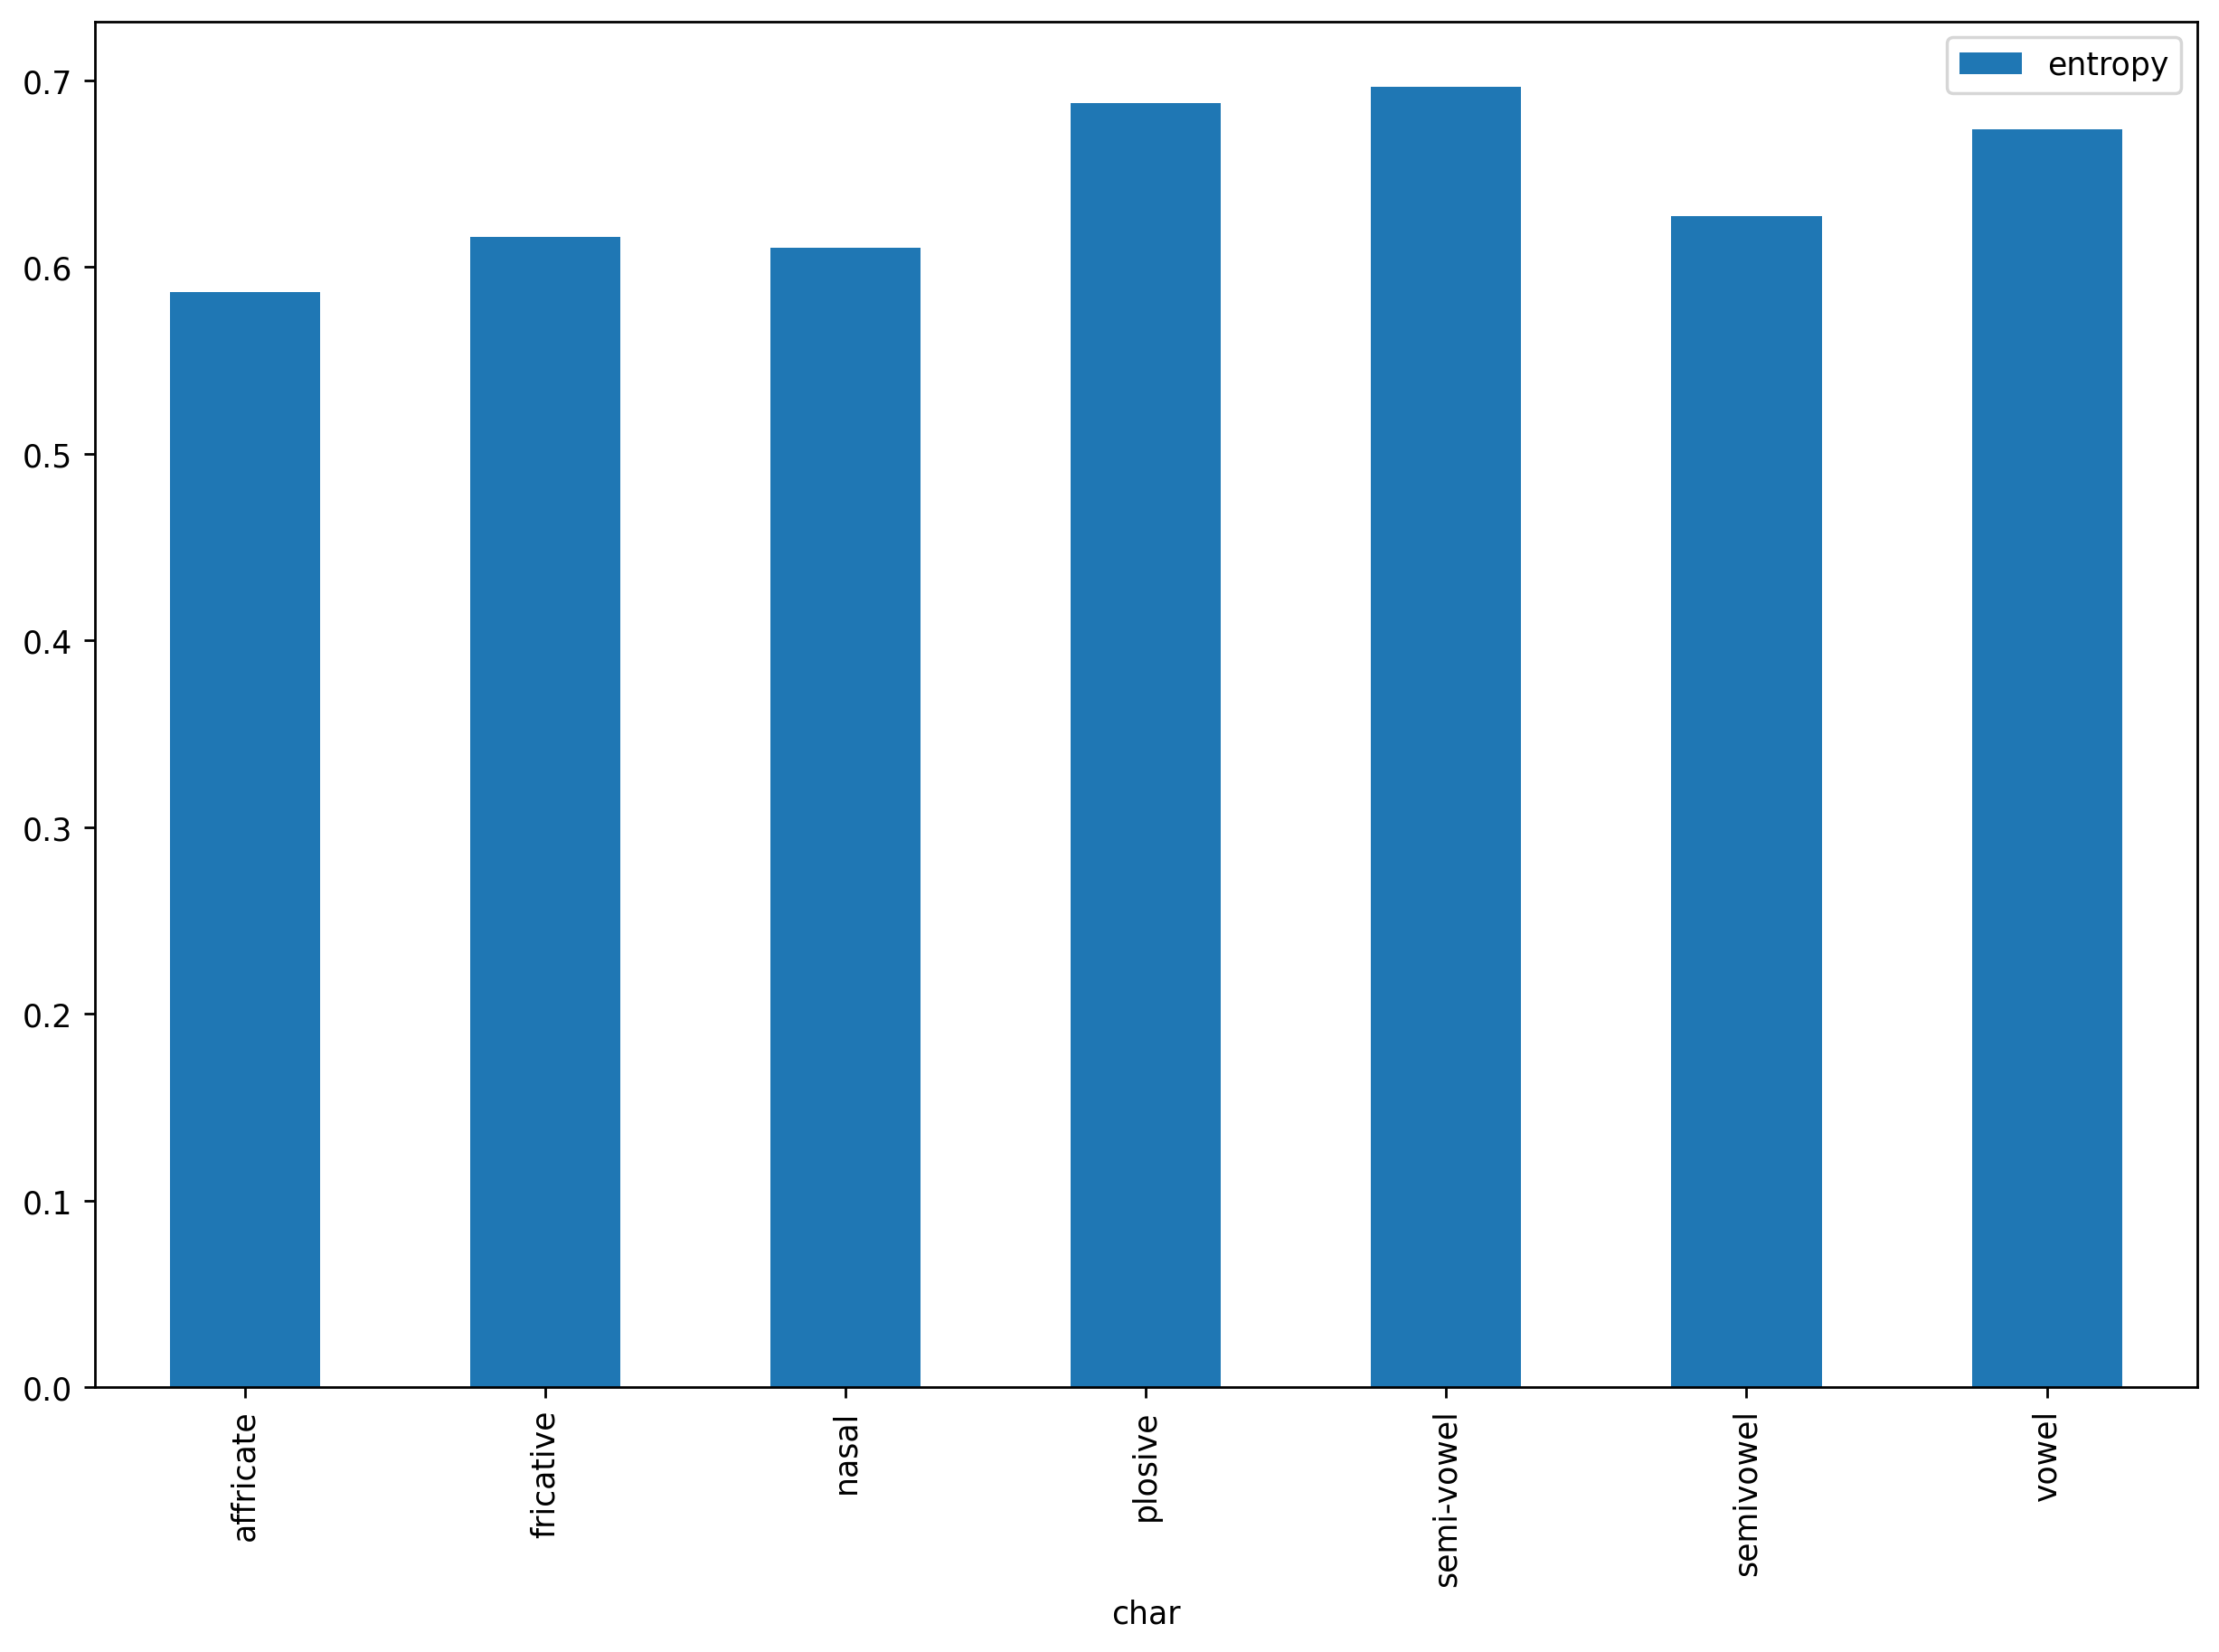

In [16]:
p2u_entropy.groupby(by="char").mean().plot.bar()

(0.0, 1.2)

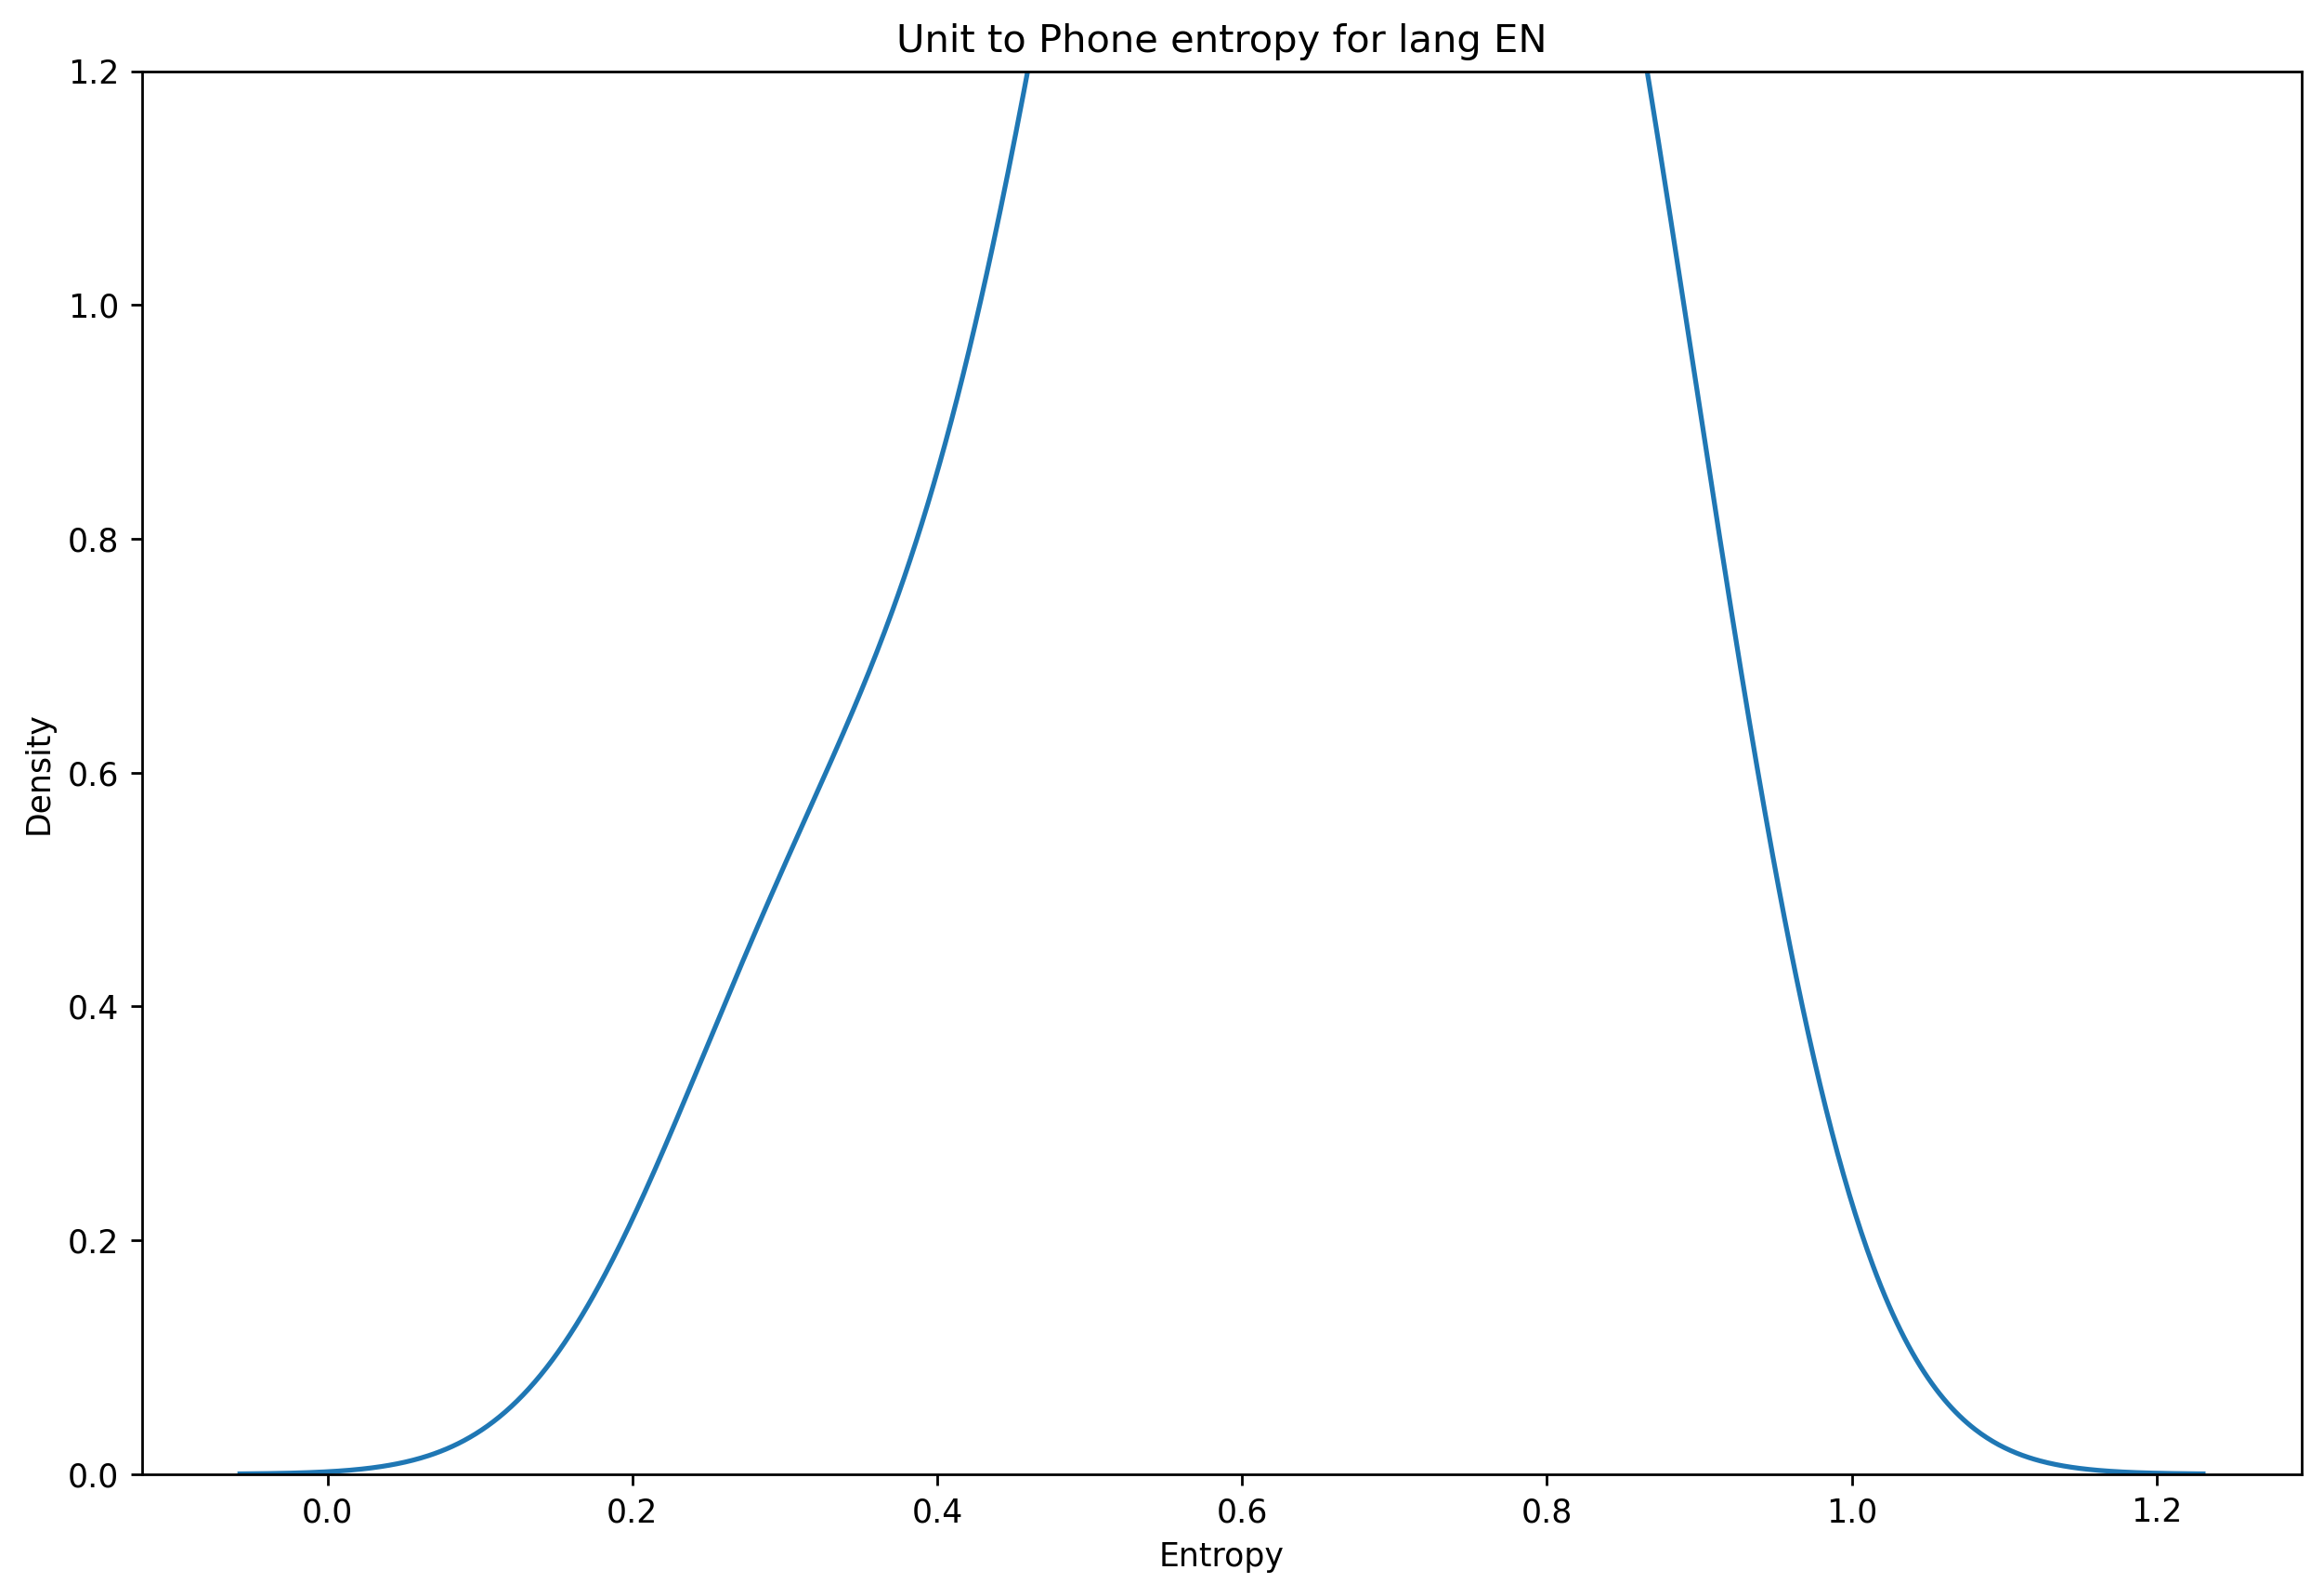

In [17]:
#u2p_entropy.plot.kde()
u2p_entropy.plot.kde(bw_method=0.55)
plt.title('Unit to Phone entropy for lang {}'.format(lang.upper()))
plt.xlabel("Entropy")
plt.ylim(0,1.2)


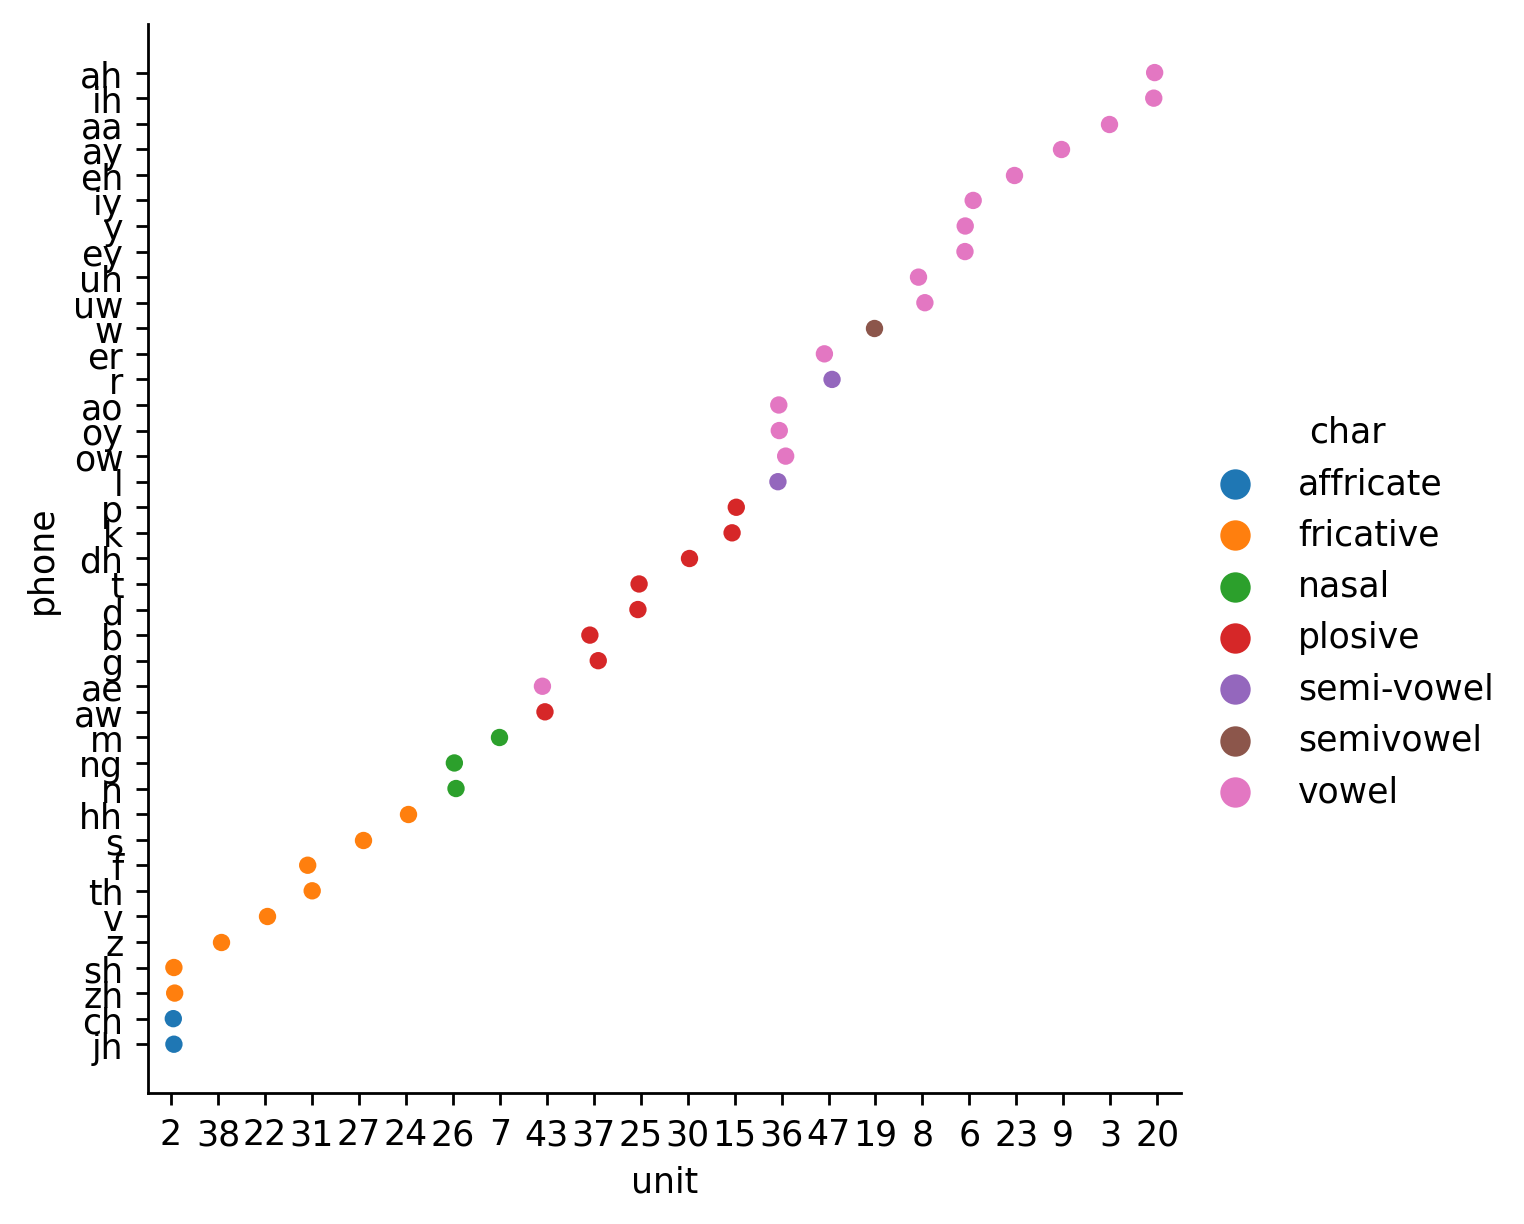

In [18]:
sns.catplot(x="unit", y="phone", data=p2u_max, hue='char')


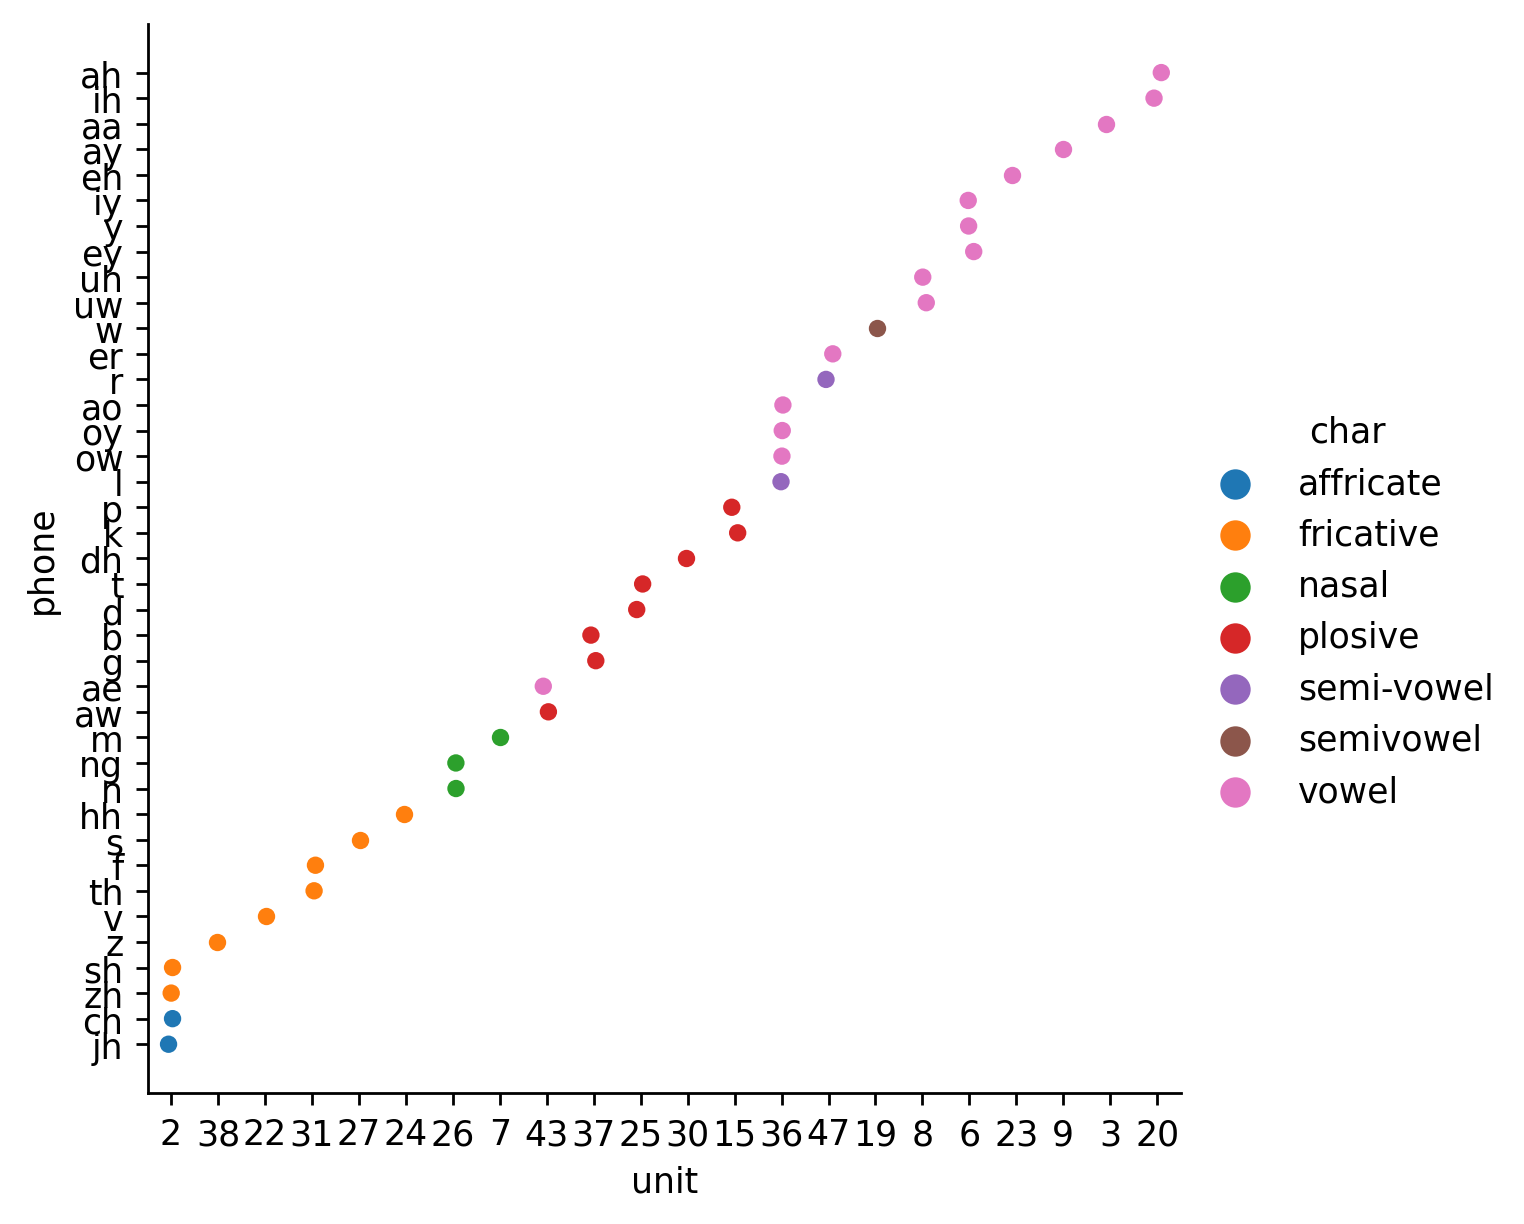

In [19]:
sns.catplot(x="unit", y="phone", data=p2u_max, hue='char')


In [20]:
p2u_max.groupby('unit')['phone'].apply(list)

unit
15              [k, p]
19                 [w]
2     [jh, ch, zh, sh]
20            [ih, ah]
22                 [v]
23                [eh]
24                [hh]
25              [d, t]
26             [n, ng]
27                 [s]
3                 [aa]
30                [dh]
31             [th, f]
36     [l, ow, oy, ao]
37              [g, b]
38                 [z]
43            [aw, ae]
47             [r, er]
6          [ey, y, iy]
7                  [m]
8             [uw, uh]
9                 [ay]
Name: phone, dtype: object

In [21]:
p2u_max.groupby('phone')['unit'].apply(list)

phone
aa     [3]
ae    [43]
ah    [20]
ao    [36]
aw    [43]
ay     [9]
b     [37]
ch     [2]
d     [25]
dh    [30]
eh    [23]
er    [47]
ey     [6]
f     [31]
g     [37]
hh    [24]
ih    [20]
iy     [6]
jh     [2]
k     [15]
l     [36]
m      [7]
n     [26]
ng    [26]
ow    [36]
oy    [36]
p     [15]
r     [47]
s     [27]
sh     [2]
t     [25]
th    [31]
uh     [8]
uw     [8]
v     [22]
w     [19]
y      [6]
z     [38]
zh     [2]
Name: unit, dtype: object

In [22]:
ax = sns.heatmap(p2u_max.groupby('unit')['phone'].apply(list))

IndexError: Inconsistent shape between the condition and the input (got (22, 1) and (22,))

In [ ]:
ax = sns.heatmap(pd.get_dummies(p2u_max['unit']),  cmap="YlGnBu")


In [ ]:
ax = sns.heatmap(p2u_df_prob,  cmap="Reds", mask=p2u_df_prob < 0.03, xticklabels=True, yticklabels=True)


In [ ]:
p2u_df_prob

In [ ]:
u2p_df_prob

In [ ]:
ax = sns.heatmap(p2u_df_prob,  cmap="YlGnBu")
for tick in ax.get_yticklabels():
    tick.set_rotation(45)

In [ ]:
w2p.keys()

In [ ]:
w2u['common_voice_en_617228'][328:]

In [ ]:
w2p['common_voice_en_617228'][328:]

In [ ]:
p2u_df_prob.sum()

In [ ]:
#get entropy

p2u_df.apply(scipy.stats.entropy)

In [ ]:
p2u_df.apply(scipy.stats.entropy)

In [ ]:
import scipy.stats

def ent(data):
    """Calculates entropy of the passed `pd.Series`
    """
    p_data = data.value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data)  # get entropy from counts
    return entropy


In [ ]:
scipy.stats.entropy(p2u_df['ah'])

In [ ]:
scipy.stats.entropy(p2u_df_prob['ah'])

In [ ]:
p2u_df['dh']

In [ ]:
x=[item for sublist in w2t.values() for item in sublist if item[0] != 'SIL']
set([p[0] for p in x])

In [ ]:
f2t = [item for sublist in w2t.values() for item in sublist if all([item[0] != 'SIL', item[1]])]

def calc_phone_distrib(f2t):
    phones = set([p[0] for p in f2t]) # phoneme classes
    units = set([p[1] for p in f2t]) # kmeanclasses
    
    joint_distrib = {}
    
    for i in tqdm(phones):
        for j in units:
            joint_distrib[(i,j)] = f2t.count((i,j))/len(f2t)
    
    return joint_distrib
            
        

def get_most_likely(joint_distrib, f2t):
    phones = set([p[0] for p in f2t]) # phoneme classes
    units = set([p[1] for p in f2t]) # kmeanclasses
    
    p2u_max={}
    for i in phones:
        d = {v:k for v,k in joint_distrib.items() if v[0] == i}
        p2u_max[i] = max(d, key=d.get)[1]
    
    u2p_max = {}
    for j in units:
        d = {v:k for v,k in joint_distrib.items() if v[1] == j}
        u2p_max[j] = max(d, key=d.get)[0]

    return p2u_max, u2p_max


def phone_purity(f2t, joint_distrib):
    p2u_max, u2p_max = get_most_likely(joint_distrib, f2t)
    av=[]
    for i,j in tqdm(f2t):
        av.append(joint_distrib[(u2p_max[j], j)])
    
    return np.array(av).mean()
    

def cluster_purity(f2t, joint_distrib):
    p2u_max, u2p_max = get_most_likely(joint_distrib, f2t)
    av=[]
    for i,j in tqdm(f2t):
        av.append(joint_distrib[(i, p2u_max[i])])
    
    return np.array(av).mean()
    
    

In [ ]:
5/0

In [ ]:
joint_distrib


In [ ]:
sorted(joint_distrib.items(), key=lambda x: x[1], reverse=True)

In [ ]:
np.array([x for x in joint_distrib.values()]).sum()

In [ ]:
joint_distrib = calc_phone_distrib(f2t)
p2u_max, u2p_max = get_most_likely(joint_distrib, f2t)

In [ ]:
phone_purity(f2t, joint_distrib)


In [ ]:
cluster_purity(f2t, joint_distrib)

In [32]:
from sklearn.manifold import TSNE
import time

In [33]:
time_start = time.time()
tsne = TSNE(verbose=1)
tsne_results = tsne.fit_transform(u2p_df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 38 nearest neighbors...
[t-SNE] Indexed 39 samples in 0.000s...
[t-SNE] Computed neighbors for 39 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 39 / 39
[t-SNE] Mean sigma: 26183.569810
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.030491
[t-SNE] KL divergence after 1000 iterations: 0.749805
t-SNE done! Time elapsed: 1389.4765737056732 seconds


In [35]:
u2p_df['tsne-2d-one'] = tsne_results[:,0]
u2p_df['tsne-2d-two'] = tsne_results[:,1]

In [37]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="char",
    palette=sns.color_palette("hls", 10),
    data=u2p_df,
    legend="full",
    alpha=0.3
)

ValueError: Could not interpret value `char` for parameter `hue`

<Figure size 4000x2500 with 0 Axes>

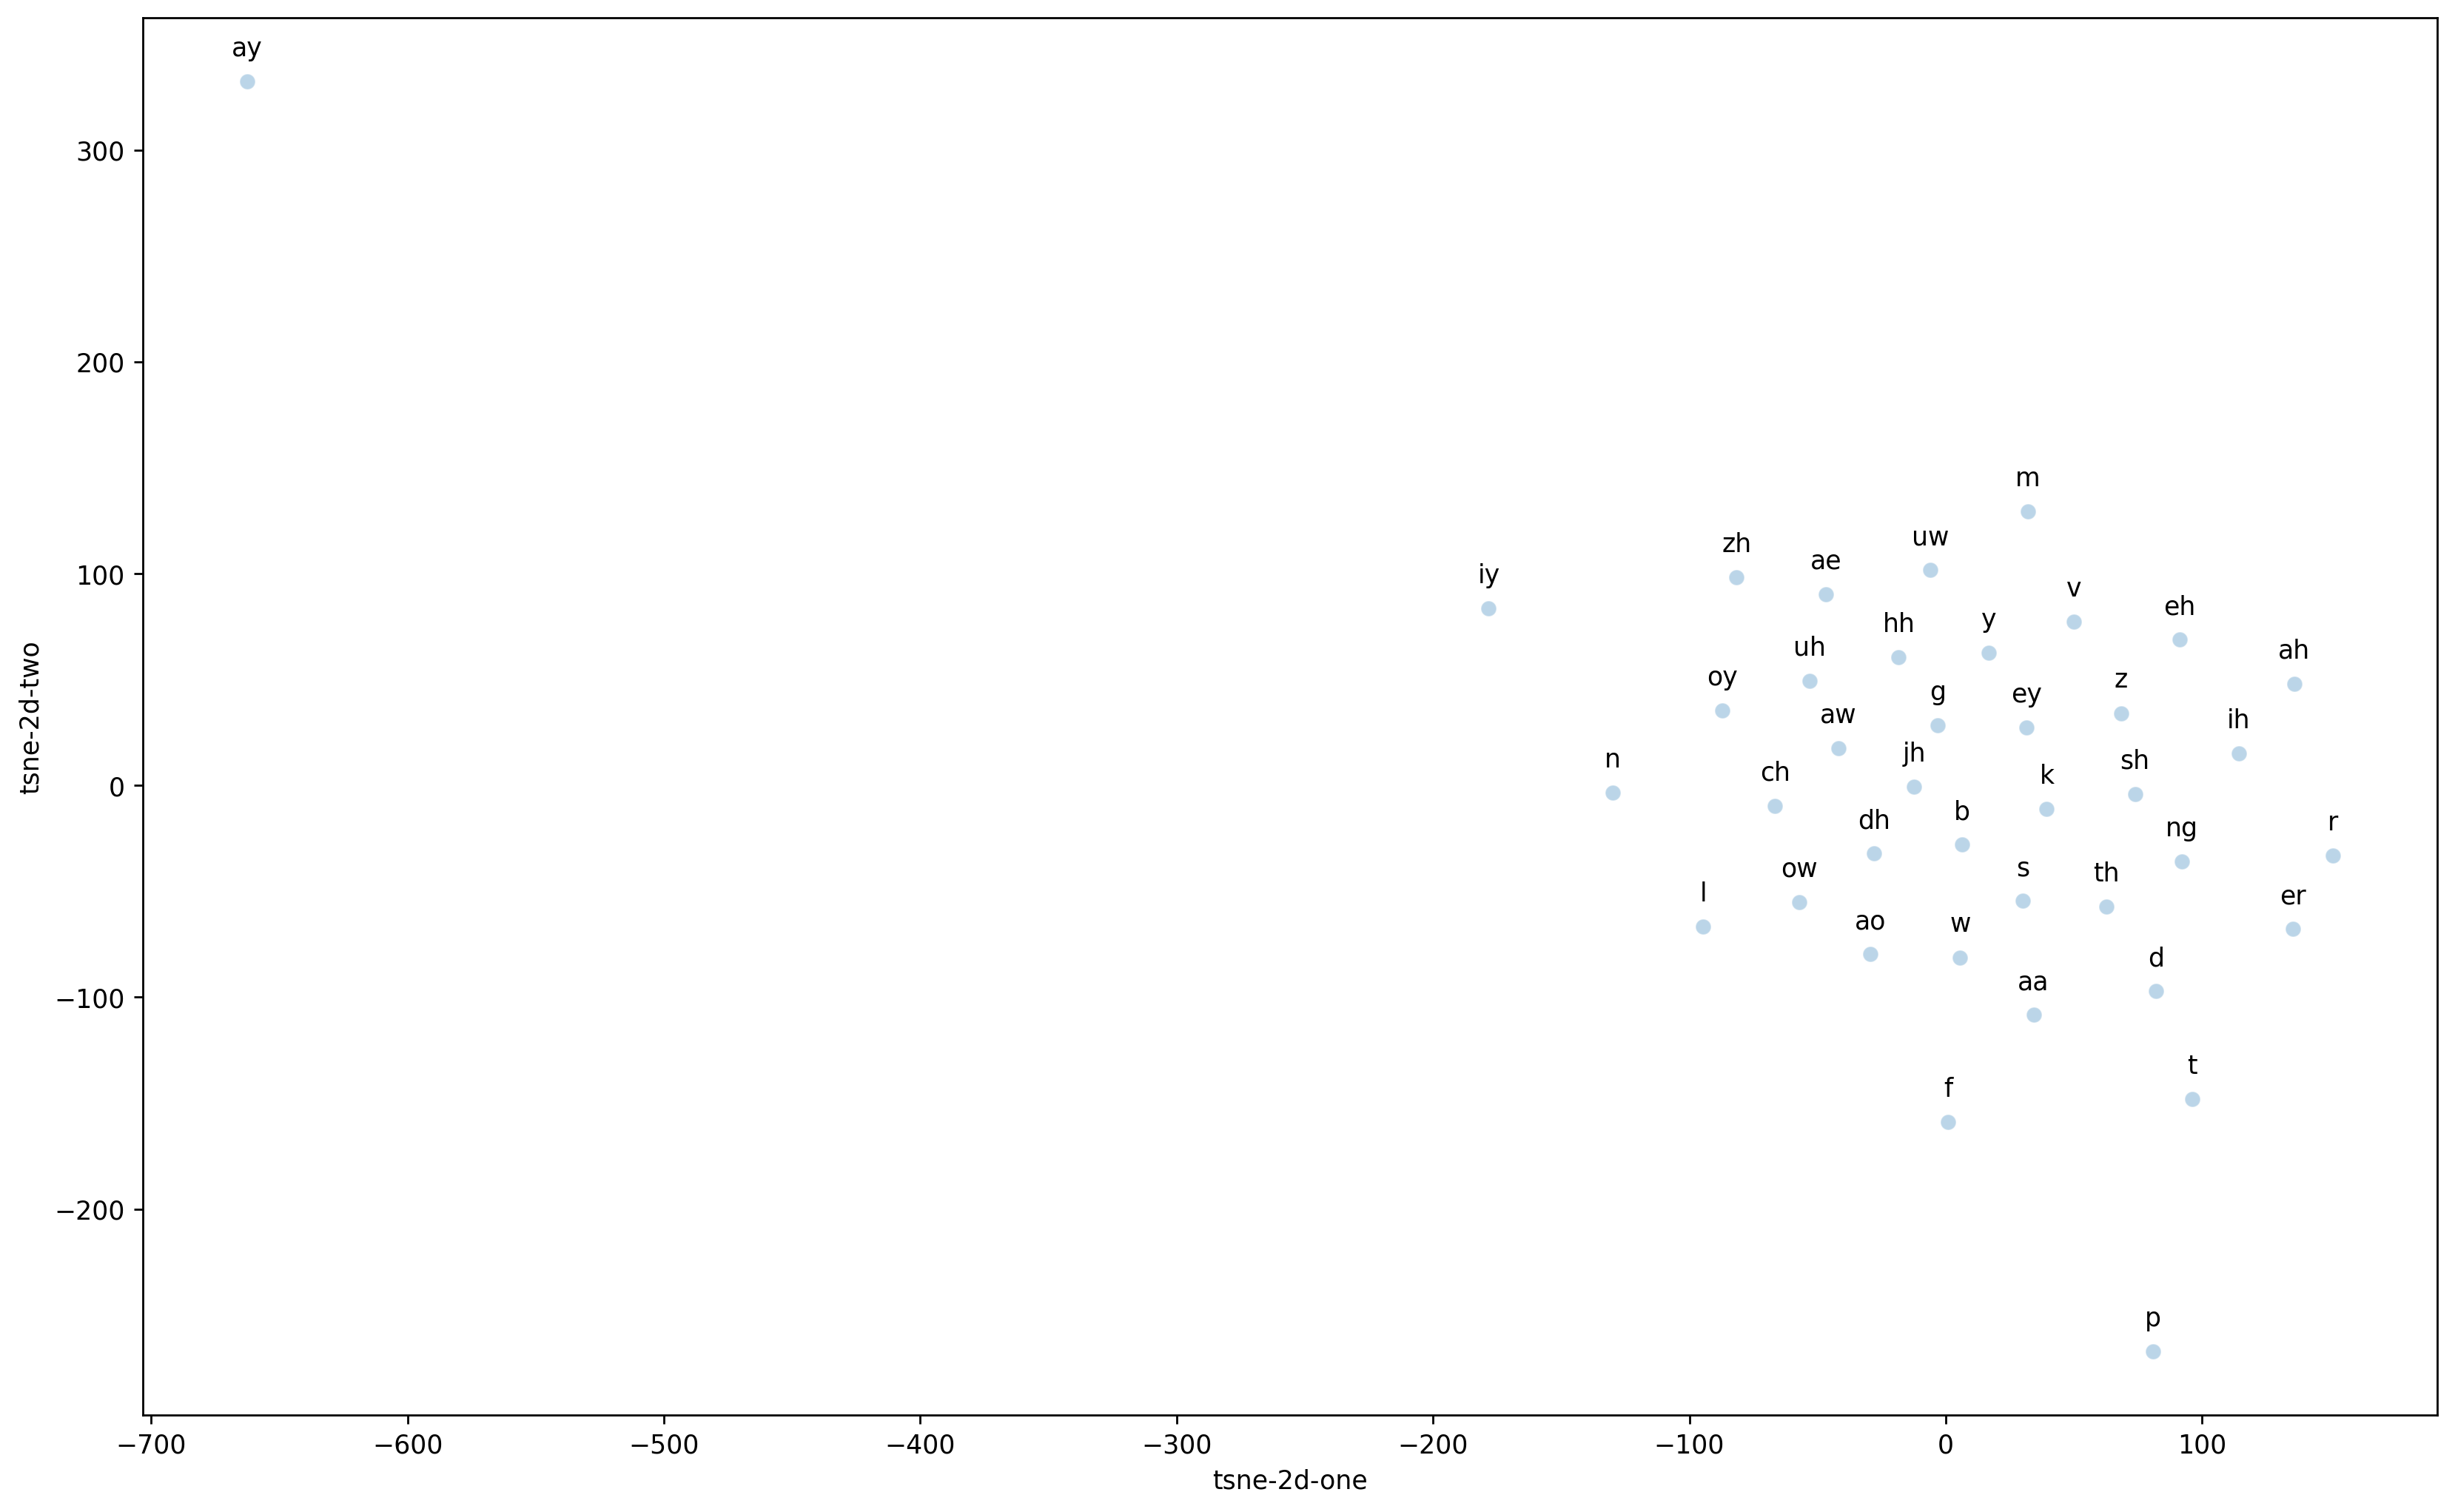

In [43]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=u2p_df,
    legend="full",
    alpha=0.3
)

for x,y,z in zip(u2p_df["tsne-2d-one"], u2p_df["tsne-2d-two"], u2p_df.index):
    plt.annotate(z, (x,y), textcoords="offset points", xytext=(0,10),ha='center')


In [41]:
u2p_df

,12,30,46,7,20,37,41,23,43,17,...,35,4,40,48,49,16,45,21,tsne-2d-one,tsne-2d-two
dh,2502.0,5850.0,2515,2041,166,3985,5171.0,10.0,22.0,179,...,63,1243,21,289,25.0,5.0,396.0,6.0,-27.980089,-32.226463
jh,137.0,330.0,1132,80,42,1431,2.0,17.0,12.0,158,...,41,606,12,41,10.0,2.0,8.0,0.0,-12.428634,-0.508170
n,556.0,915.0,4082,17520,4490,7233,212.0,187.0,841.0,11693,...,826,2479,788,5391,380.0,309.0,72.0,3.0,-129.874725,-3.275131
m,590.0,946.0,2195,29299,314,2066,78.0,105.0,326.0,3408,...,184,1633,510,647,219.0,72.0,58.0,0.0,32.001572,129.251694
ae,565.0,1509.0,1603,92,4237,54,323.0,10146.0,15166.0,363,...,423,1151,151,2496,1749.0,14254.0,86.0,0.0,-46.659573,90.251610
p,384.0,1220.0,441,134,35,1571,56.0,40.0,96.0,412,...,28,246,22,92,57.0,5.0,109.0,3.0,80.824951,-267.204468
w,588.0,1666.0,1181,1145,53,511,21.0,222.0,27.0,270,...,34,648,395,49,244.0,116.0,87.0,0.0,5.570508,-81.161423
ao,189.0,533.0,279,125,215,21,52.0,31.0,2419.0,268,...,4,155,1335,305,7615.0,20.0,46.0,0.0,-29.320154,-79.712547
y,107.0,535.0,1813,735,98,229,19.0,226.0,4.0,136,...,3234,710,12,35,5.0,76.0,18.0,0.0,16.709671,62.752262
ih,1178.0,2752.0,15317,906,17959,646,1487.0,8225.0,417.0,1194,...,7476,9678,1229,7496,225.0,3021.0,199.0,0.0,114.198410,14.996818
